In [1]:
%matplotlib inline
import time
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()  
import numpy as np
from sklearn.cluster import KMeans 
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_samples, silhouette_score, calinski_harabasz_score
import numba
from numba import vectorize
import tensorflow as tf
from tensorflow import keras

In [2]:
from tensorflow.keras.datasets import mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [3]:
# on normalise les données de la base mnist
normalized_x_train = x_train.astype(np.float32) / 255.
normalized_x_test = x_test.astype(np.float32) / 255.

In [4]:
# on crée des fonctions qui comptent le nombre de pixels noirs sur une ligne, ou sur une colonne
# on crée ensuite des fonctions qui calculent, sur une ligne ou colonne, la moyenne des pixels non noirs

def nb_noir_y(image):
    nb_pixels_noirs = []
    for i in range(28):
        nb_pixels_noir_ligne = 0
        for j in range(28):
            if image[i][j] == 0:
                nb_pixels_noir_ligne += 1
        nb_pixels_noirs.append(nb_pixels_noir_ligne)
    return nb_pixels_noirs

def nb_noir_x(image):
    return nb_noir_y(np.transpose(image))

def average_non_dark_x(image):
    averages = []
    for i in range(28):
        average = np.sum(image[i]) / 28
        averages.append(average)
    return averages

def average_non_dark_y(image):
    return average_non_dark_x(np.transpose(image))

def build_set():
    normalized = normalized_x_train
    labels = x_train   
    training_set = []
    for i in range(len(normalized)):
        image = normalized[i]
        dx = nb_noir_x(image)
        dy = nb_noir_y(image)
        ndx = average_non_dark_x(image)
        ndy = average_non_dark_y(image)
        tableau_image_x = []
        tableau_image_y = []
        for i in range(28):
            tableau_image_x.append(dx[i])
            tableau_image_x.append(ndx[i])
            tableau_image_y.append(dy[i])
            tableau_image_y.append(ndy[i])
        training_set.append(tableau_image_x + tableau_image_y)
    return training_set

In [5]:
#fonction qui renvoie les positions des images dans le cluster k
def creer_prediction_set(prediction, k):
    prediction_set_k = []
    for i in range(len(prediction)):
        if prediction[i] == k:
            prediction_set_k.append(i)
    return prediction_set_k

from scipy.stats import entropy
def score_entropy(prediction, num_clusters):
    entropie_moyenne_ponderee = 0
    for k in range(num_clusters):
        cluster = creer_prediction_set(prediction, k)
        entropy_cluster = entropy(cluster)
        entropie_moyenne_ponderee += len(cluster)*entropy_cluster
    entropie_moyenne_ponderee /= len(prediction)
    return entropie_moyenne_ponderee 

#avec la fonction creer_prediction_set, on a les images classées dans un meme cluster
#mais le numero du cluster n'est pas necessairement la valeur du label dominant
#cette fonction détermine quel label les images du cluster ont le plus en commun
def determiner_label(prediction):
    labels_found = {"0":0, "1":0, "2":0, "3":0, "4":0, "5":0, "6":0, "7":0, "8":0, "9":0}
    for j in range(len(prediction)):
        i = prediction[j]
        labels_found[str(y_train[i])] += 1
    real_label = 0
    for k in range(10):
        label_multiplicity = labels_found.get(str(k))
        if label_multiplicity > labels_found.get(str(real_label)):
            real_label = k
    return real_label

def erreur_cluster(prediction_set):
    label_set = determiner_label(prediction_set)
    nb_erreurs_label = 0
    for i in range(len(prediction_set)):
        label_image = y_train[prediction_set[i]]
        if label_image != label_set:
            nb_erreurs_label += 1
    return nb_erreurs_label

#cette fonction permet d'associer chaque image du set sur lequel on applique notre algorithme
#au label qu'il lui prédit
def y_predicted(clusters, n_clusters):
    clustering = []
    labelling = []
    for i in range(n_clusters):
        cluster_i = creer_prediction_set(clusters, i)
        label_i = determiner_label(cluster_i)
        clustering.append(cluster_i)
        labelling.append(label_i)
    y_predict = []
    for i in range(len(clusters)):
        k = 0
        while(i not in clustering[k]):
            k += 1
        y_predict.append(labelling[k])
    return y_predict

def erreurs_totales(clusters, n_clusters):
    labels_predicted = y_predicted(clusters, n_clusters)
    nb_erreurs=0
    for i in range(len(clusters)):
        if y_train[i] != labels_predicted[i]:
            nb_erreurs += 1
    return nb_erreurs

In [6]:
training_set = build_set()

## On commence par implémenter l'algorithme K-Means avec cette nouvelle approche de l'histogramme
### Le but final est de comparer ces résultats avec les résultats obtenus avec les images entières

In [10]:
start = time.time()
number_clusters = 20
model = KMeans(n_clusters = number_clusters)
model.fit(training_set)

clusters_predicted = model.predict(training_set)
end = time.time()
print("Durée K-Means pour", number_clusters, "clusters:", round(end - start, 2), "s")

Durée K-Means pour 20 clusters: 17.86 s


Cluster n° 15
taille cluster: 2939


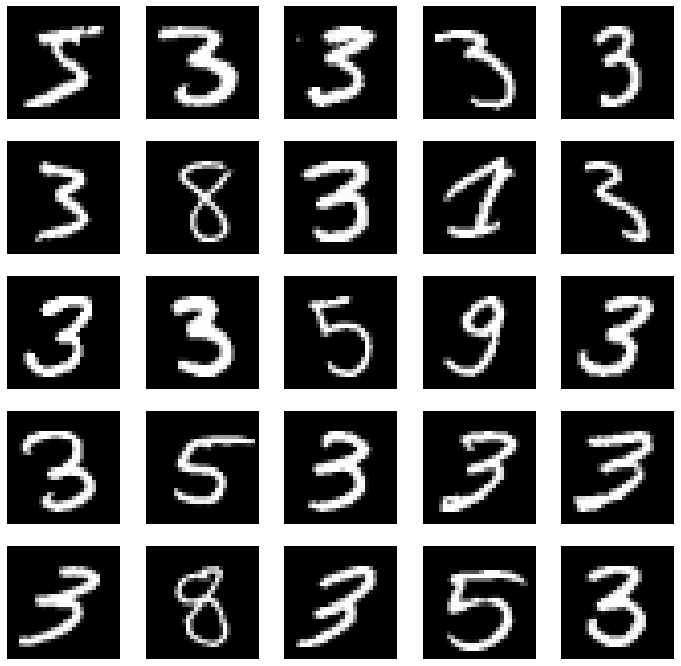


Cluster n° 18
taille cluster: 3400


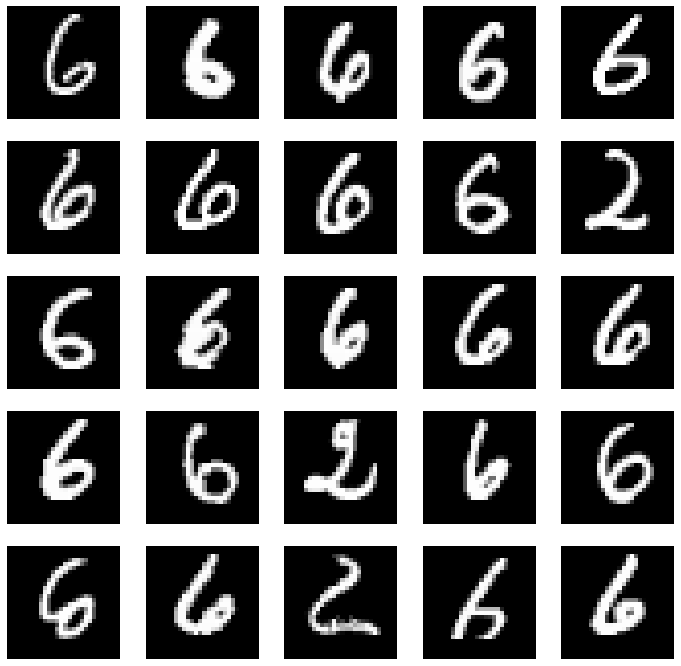

In [11]:
clusters_regardes = np.random.randint(0, number_clusters, 2)
for k in clusters_regardes:
    cluster = creer_prediction_set(clusters_predicted, k)
    print("Cluster n°", k)
    print("taille cluster:", len(cluster))
    fig, axs = plt.subplots(5, 5, figsize = (12, 12))
    plt.gray()
    for i, ax in enumerate(axs.flat):
        ax.imshow(x_train[cluster[i]])
        ax.axis('off')
    plt.show()
    print()

#### On ne peut malheureusement pas reconstruire en image les centres des clusters de K-Means, donc on ne peut pas les visualiser

In [8]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

inertia=[]
homogeneite=[]
precision=[]
silhouettes=[]
times = []
calinski = []
entropie = []

with tf.device('/device:GPU:1'):
    for k in range(2, 263, 5):
        start = time.time()
        model_loop = KMeans(n_clusters = k).fit(training_set)
        end = time.time()
        times.append(end-start)
        inertia.append(model_loop.inertia_)

        homogen_loop = homogeneity_score(y_train, model_loop.labels_)
        homogeneite.append(homogen_loop)

        nb_erreurs_loop = erreurs_totales(model_loop.labels_, k, "train")
        pourcentage_erreur_loop = nb_erreurs_loop/len(training_set)
        precision_k = 1-pourcentage_erreur_loop
        precision.append(precision_k)

        cluster_labels_pour_sil = model_loop.fit_predict(training_set)
        silhouette_avg = silhouette_score(training_set, cluster_labels_pour_sil)
        silhouettes.append(silhouette_avg)

        calinski_k = calinski_harabasz_score(training_set, model_loop.labels_)
        calinski.append(calinski_k)

        entropie_k = score_entropy(model_loop.labels_, k)
        entropie.append(entropie_k)

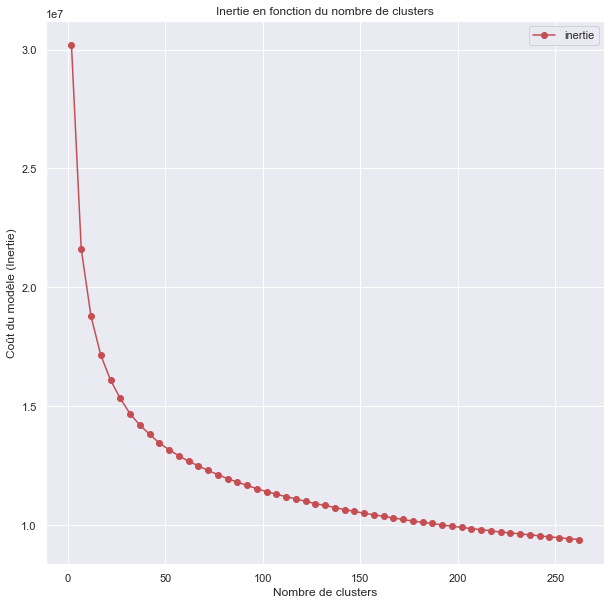

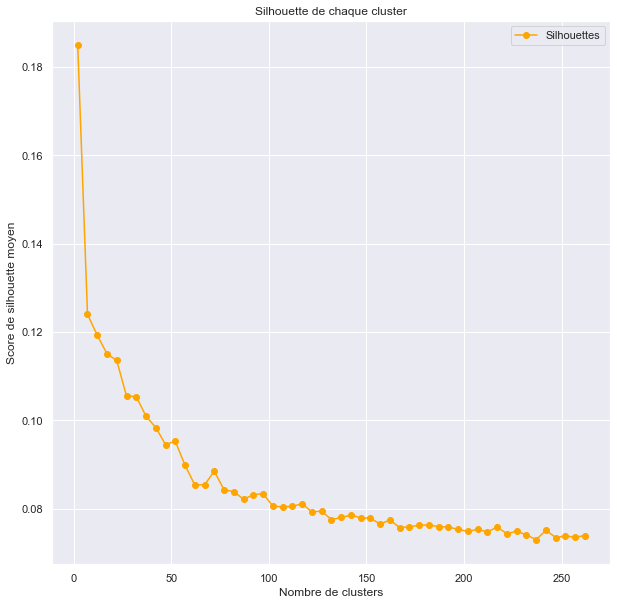

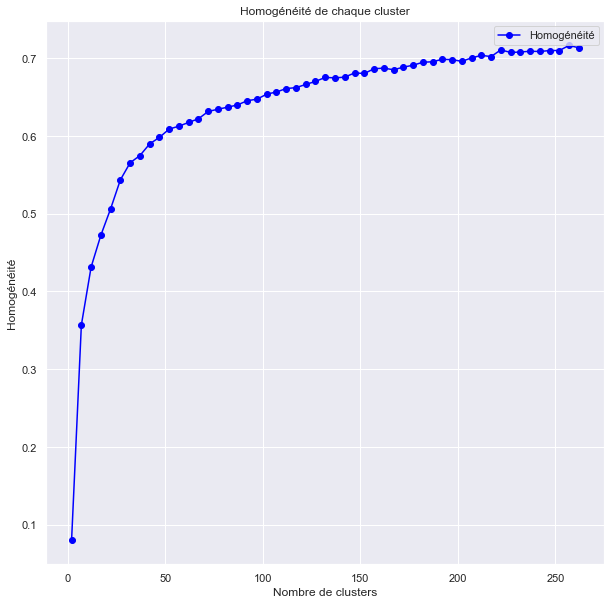

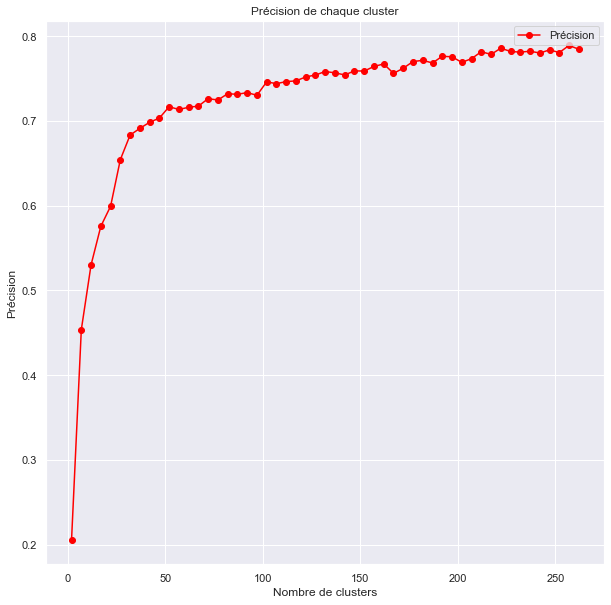

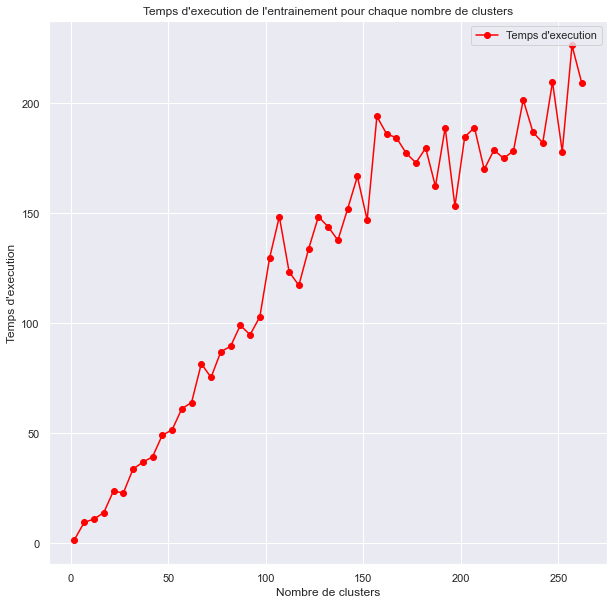

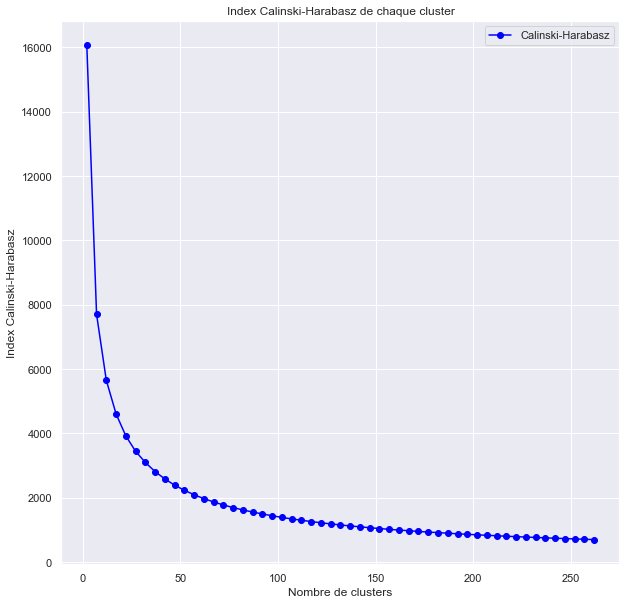

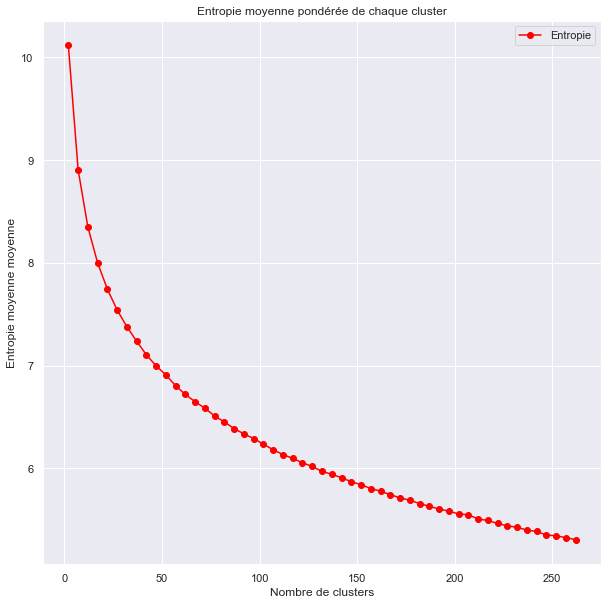

In [9]:
points = []
for i in range(2, 263, 5):
    points.append(i)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, silhouettes, label='Silhouettes', c='orange', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de silhouette moyen')
ax.grid('on')
ax.set_title('Silhouette de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, homogeneite, label='Homogénéité', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Homogénéité')
ax.grid('on')
ax.set_title('Homogénéité de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, precision, label='Précision', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Précision')
ax.grid('on')
ax.set_title('Précision de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, times, label="Temps d'execution", c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel("Temps d'execution")
ax.grid('on')
ax.set_title("Temps d'execution de l'entrainement pour chaque nombre de clusters")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, calinski, label='Calinski-Harabasz', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Index Calinski-Harabasz')
ax.grid('on')
ax.set_title('Index Calinski-Harabasz de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, entropie, label='Entropie', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Entropie moyenne moyenne')
ax.grid('on')
ax.set_title('Entropie moyenne pondérée de chaque cluster')
plt.show()

## K-Medoids

In [9]:
import tensorflow as tf
tf.debugging.set_log_device_placement(True)

with tf.device('/device:GPU:1'):
    number_clusters = 20
    start = time.time()

    model = KMedoids(n_clusters = number_clusters)
    model.fit(training_set)

    clusters_predicted = model.predict(training_set) 
    centers = model.cluster_centers_

    end = time.time()
    print("Durée Kmedoids:", end-start)

Durée Kmedoids: 254.12708020210266


taille cluster: 1497



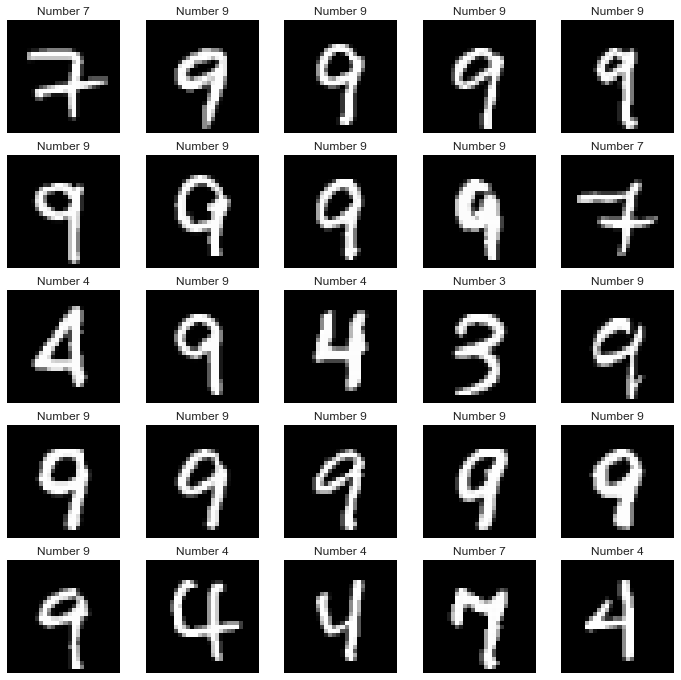

taille cluster: 1759



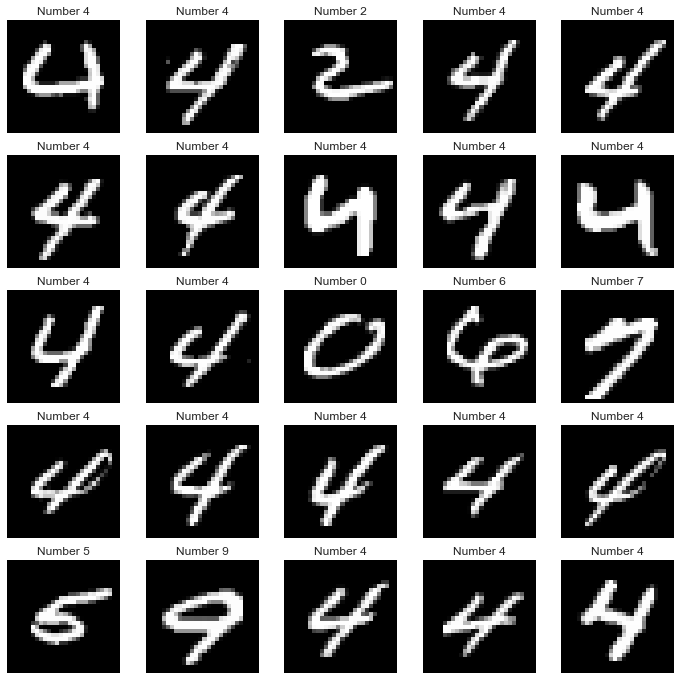

taille cluster: 1790



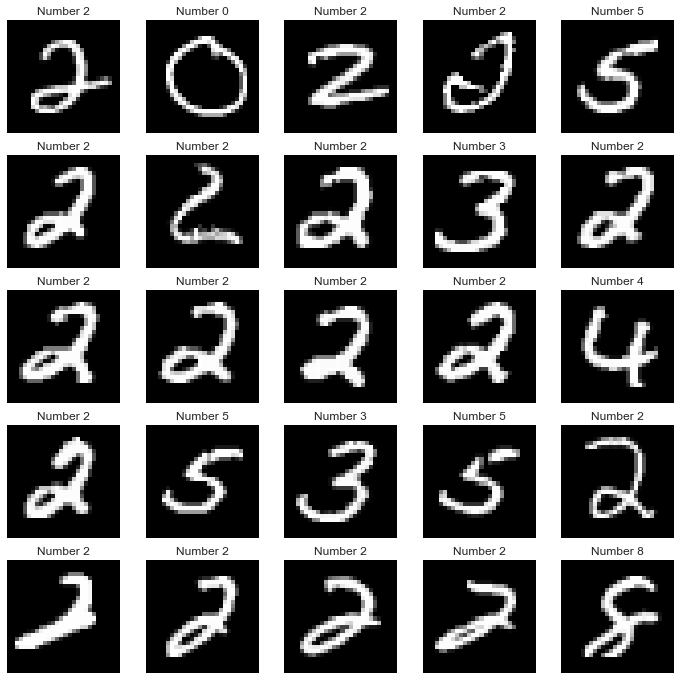

taille cluster: 883



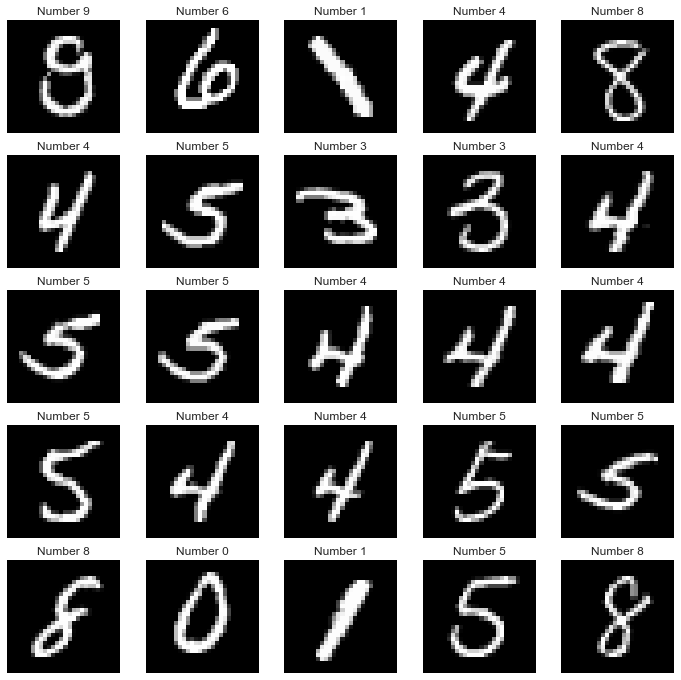

taille cluster: 3281



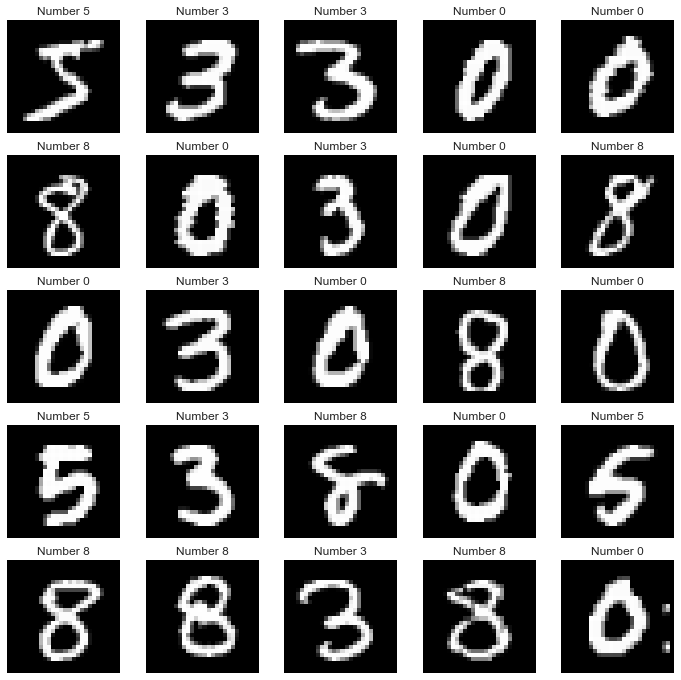

taille cluster: 1642



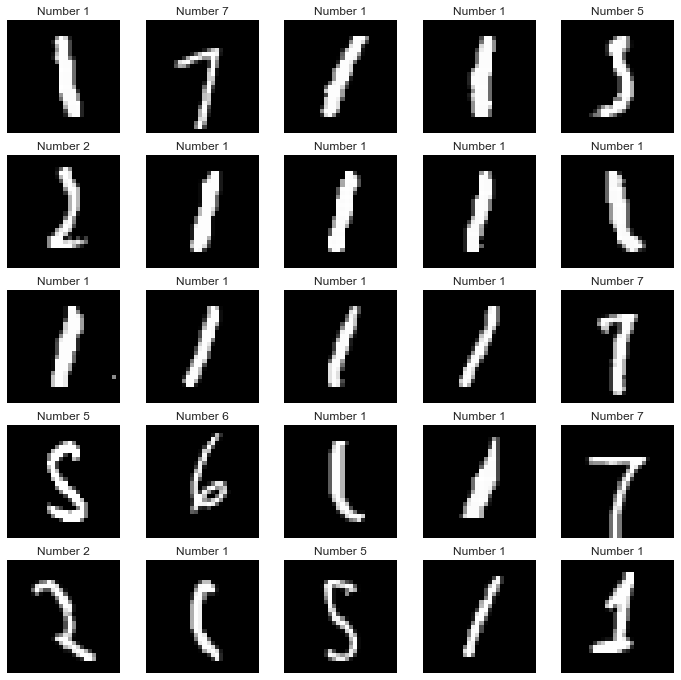

taille cluster: 2141



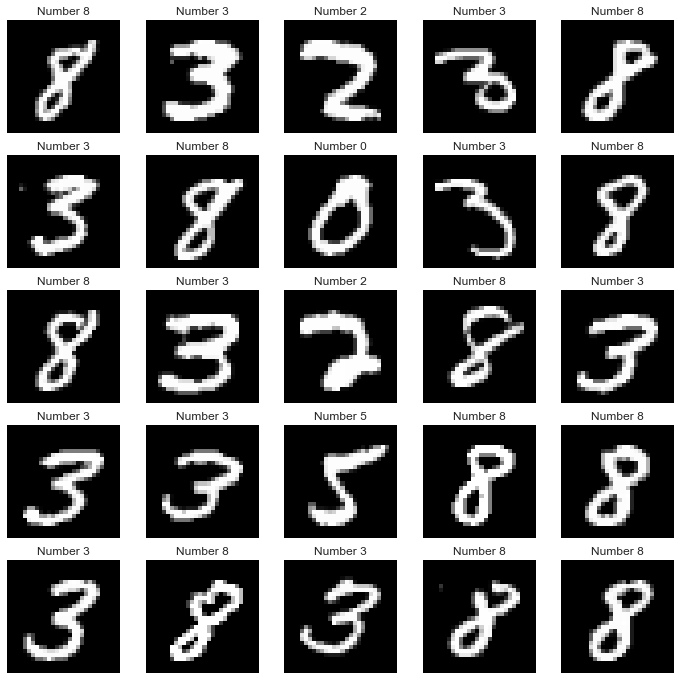

taille cluster: 1364



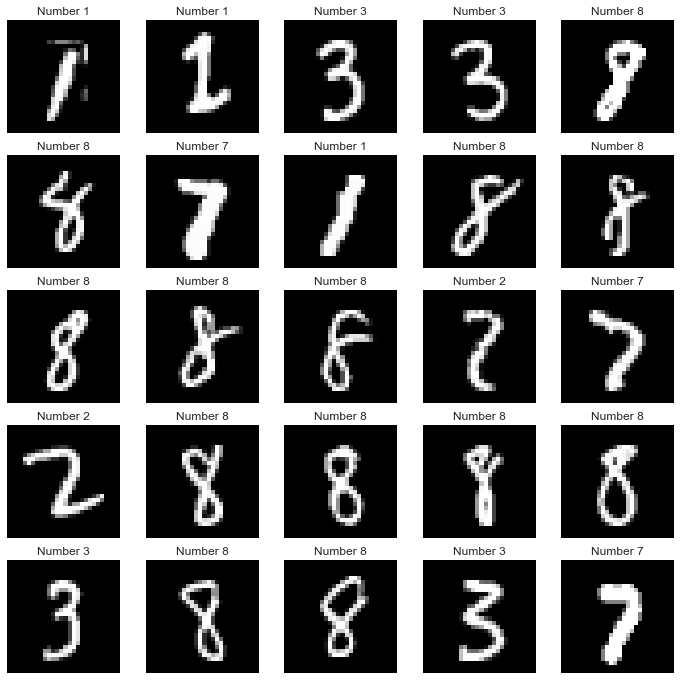

taille cluster: 4942



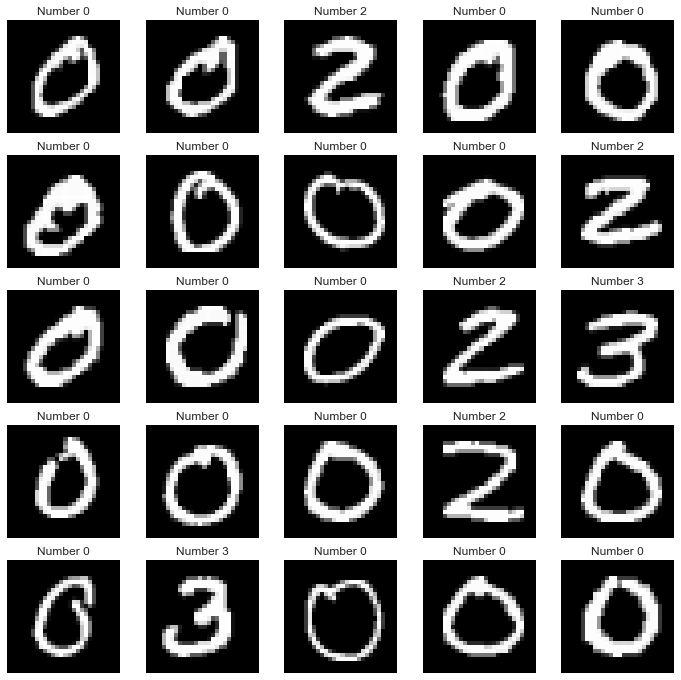

taille cluster: 1599



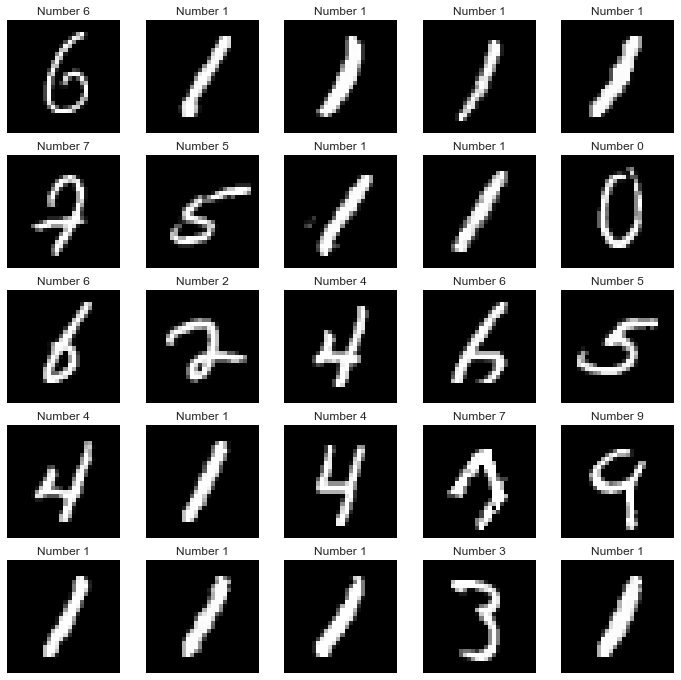

taille cluster: 2588



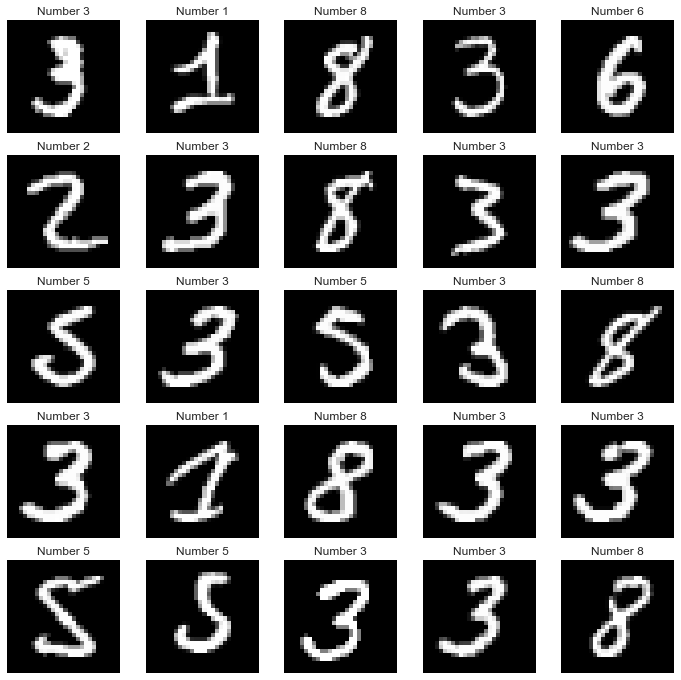

taille cluster: 1746



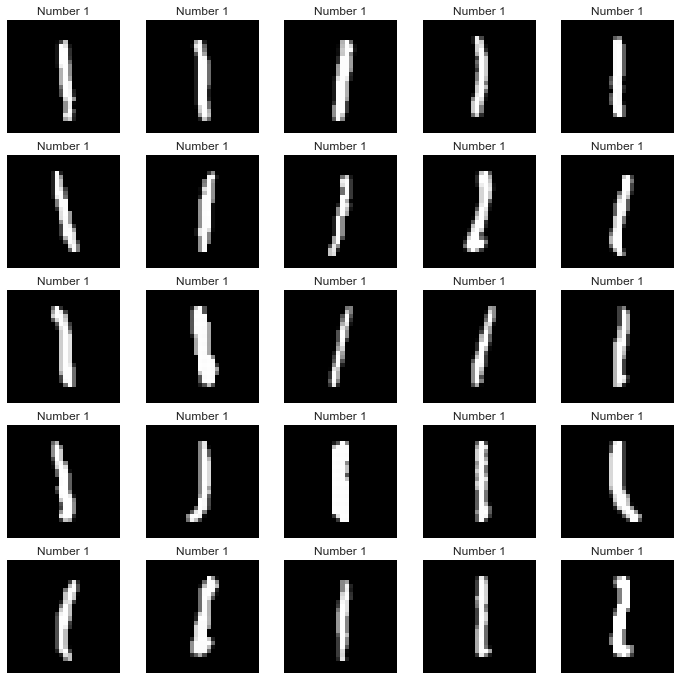

taille cluster: 1988



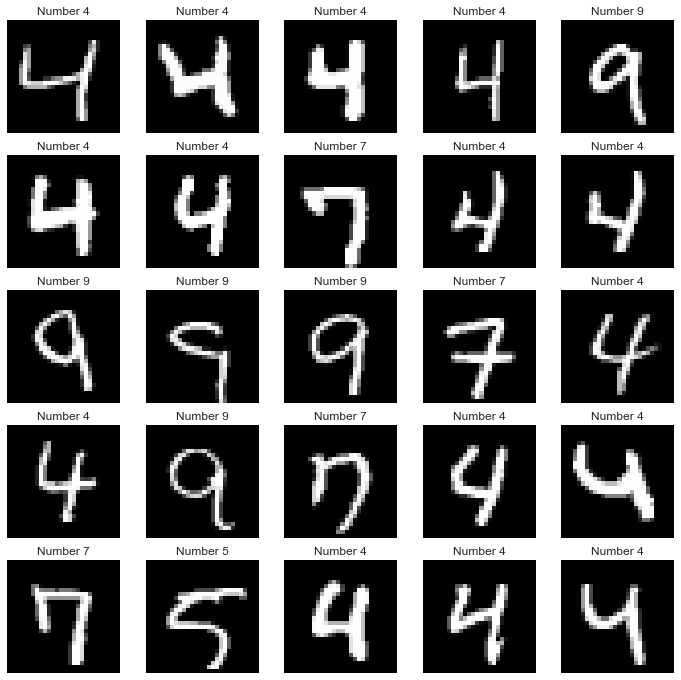

taille cluster: 1513



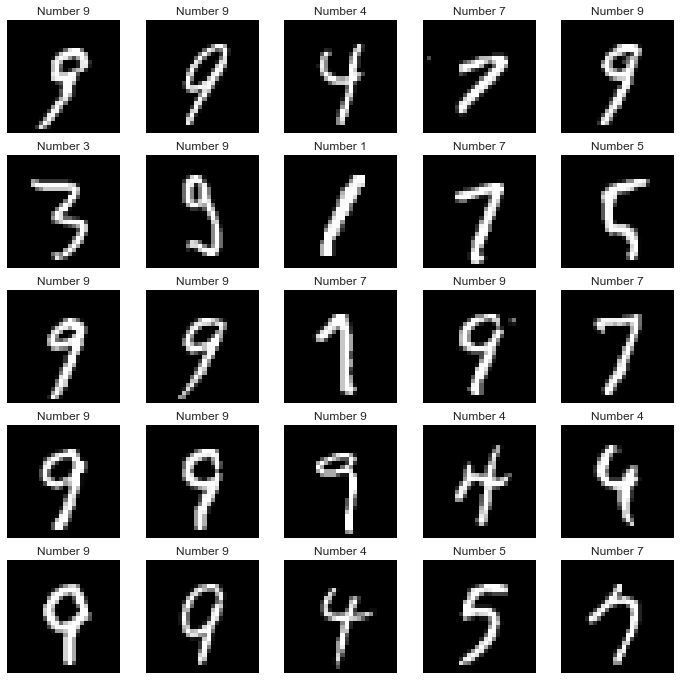

taille cluster: 1603



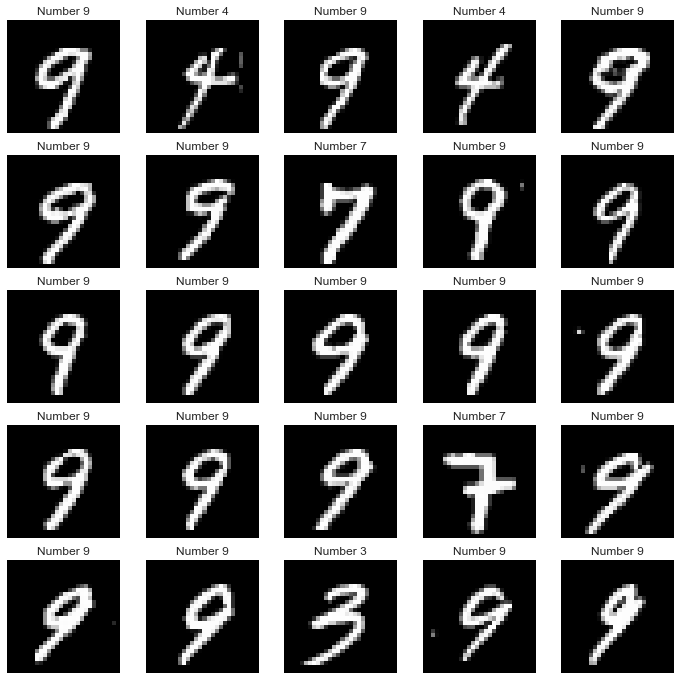

taille cluster: 2822



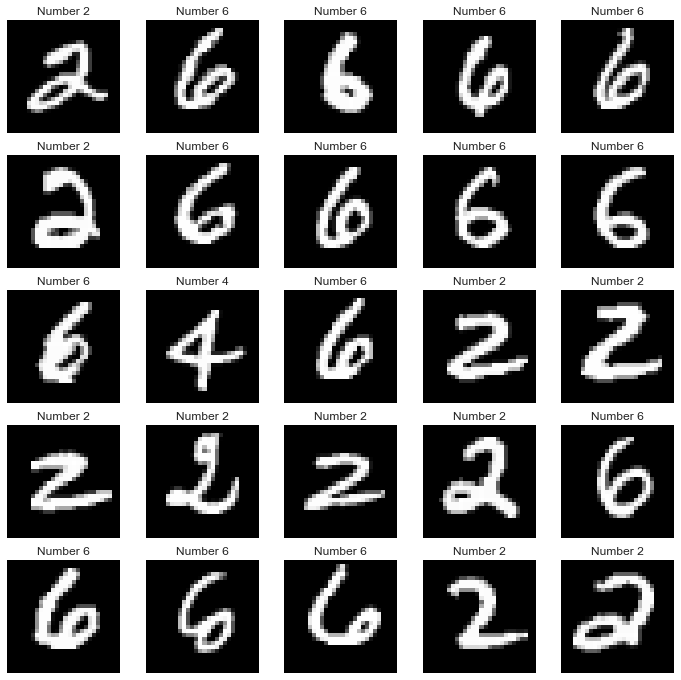

taille cluster: 1291



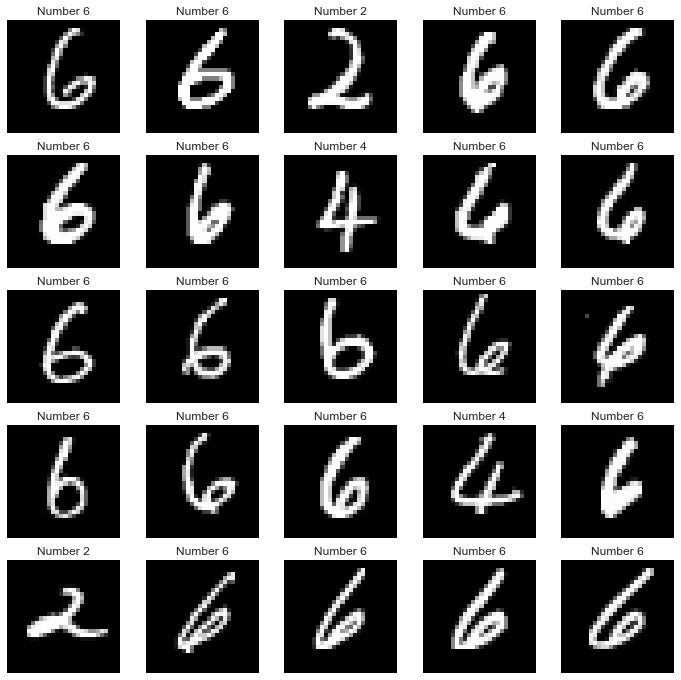

taille cluster: 1597



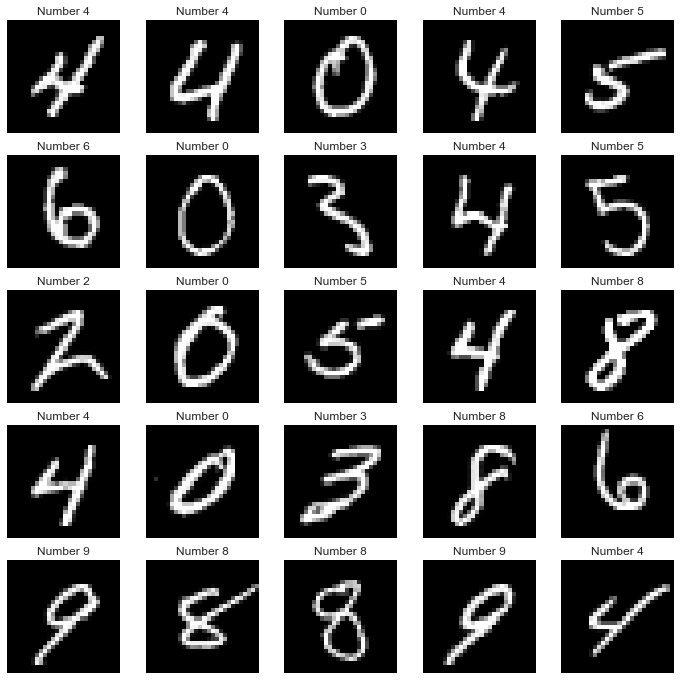

taille cluster: 2828



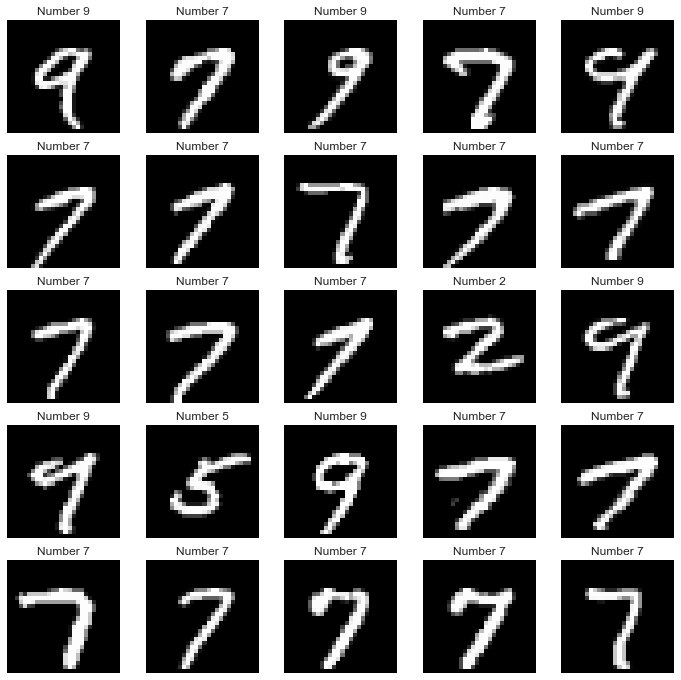

taille cluster: 1126



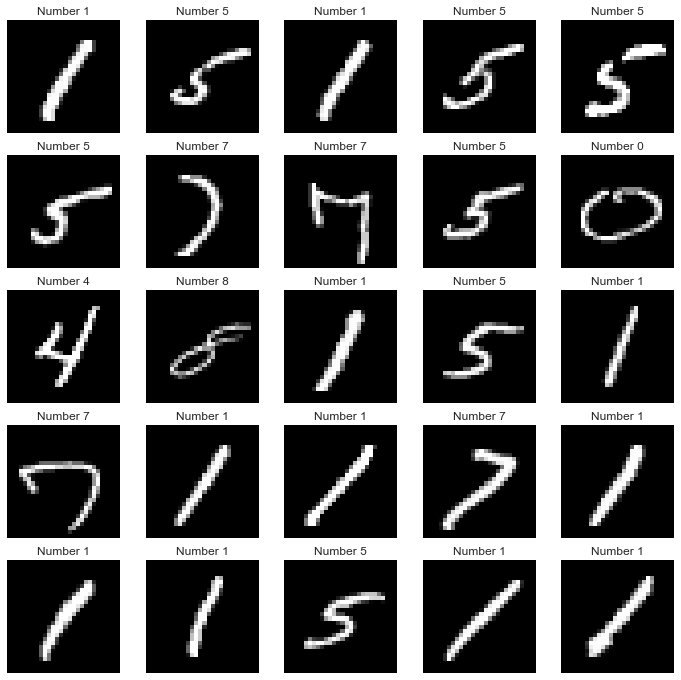

In [10]:
for k in range(number_clusters):
    cluster = creer_prediction_set(clusters_predicted, k)
    print("Cluster n°", k)
    print("taille cluster:", len(cluster))
    fig, axs = plt.subplots(5, 5, figsize = (12, 12))
    plt.gray()
    for i, ax in enumerate(axs.flat):
        ax.imshow(x_train[cluster[i]])
        ax.axis('off')
    plt.show()
    print()

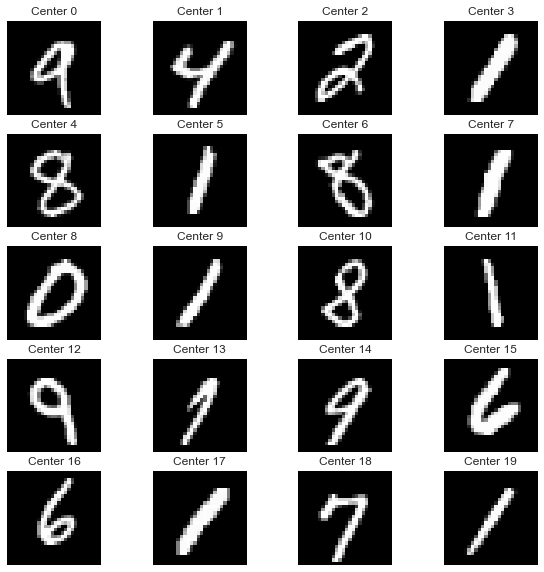

In [11]:
# visualisons les centres de chaque cluster
# au contraire de K-Means, on peut visualiser les centres des clusters dans le cas de K-Medoids
# car les centres correspondent effecitvement à des images du set d'entrée
centroids_indices = model.medoid_indices_

fig, axs = plt.subplots(5, 4, figsize = (10, 10))
plt.gray()
for i, ax in enumerate(axs.flat):
    ax.imshow(x_train[positions[centroids_indices[i]]])
    ax.axis('off')
    ax.set_title('Center {}'.format(i))
    
plt.show()


In [12]:
from sklearn.metrics import homogeneity_score
from sklearn.metrics import accuracy_score
import tensorflow as tf
tf.debugging.set_log_device_placement(True)


inertia=[]
homogeneite=[]
precision=[]
silhouettes=[]
times = []
calinski = []
entropie = []

with tf.device('/device:GPU:0'):
    for k in range(2, 263, 10):
        start = time.time()
        model_loop = KMedoids(n_clusters = k)
        model_loop.fit(training_set)
        end = time.time()
        times.append(end-start)
        inertia.append(model_loop.inertia_)

        homogen_loop = homogeneity_score(y_train, model_loop.labels_)
        homogeneite.append(homogen_loop)

        nb_erreurs_loop = erreurs_totales(model_loop.labels_, k, "train")
        pourcentage_erreur_loop = nb_erreurs_loop/len(training_set)
        precision_k = 1-pourcentage_erreur_loop
        precision.append(precision_k)

        cluster_labels_pour_sil = model_loop.predict(training_set)
        silhouette_avg = silhouette_score(training_set, cluster_labels_pour_sil)
        silhouettes.append(silhouette_avg)

        calinski_k = calinski_harabasz_score(training_set, model_loop.labels_)
        calinski.append(calinski_k)

        entropie_k = score_entropy(model_loop.labels_, k)
        entropie.append(entropie_k)

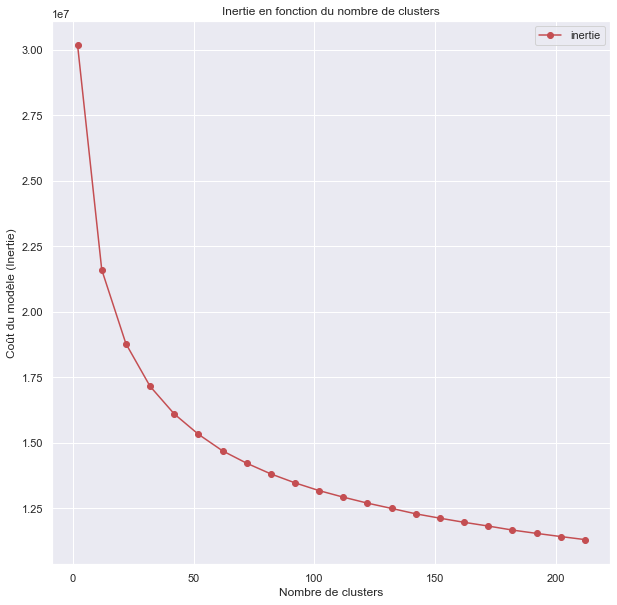

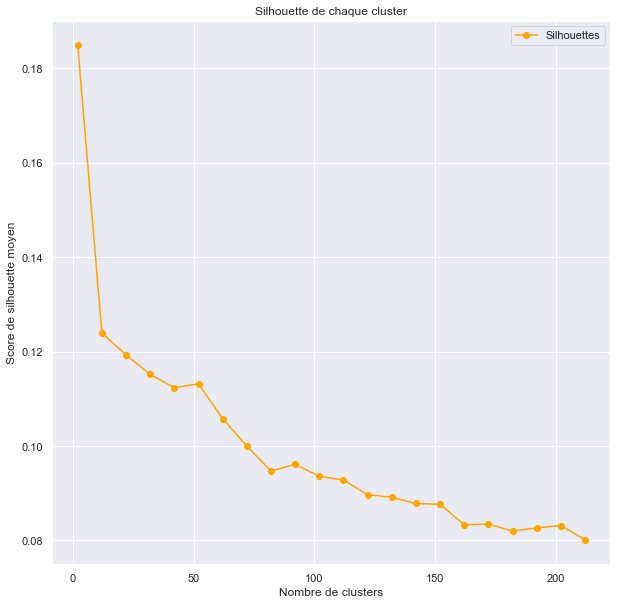

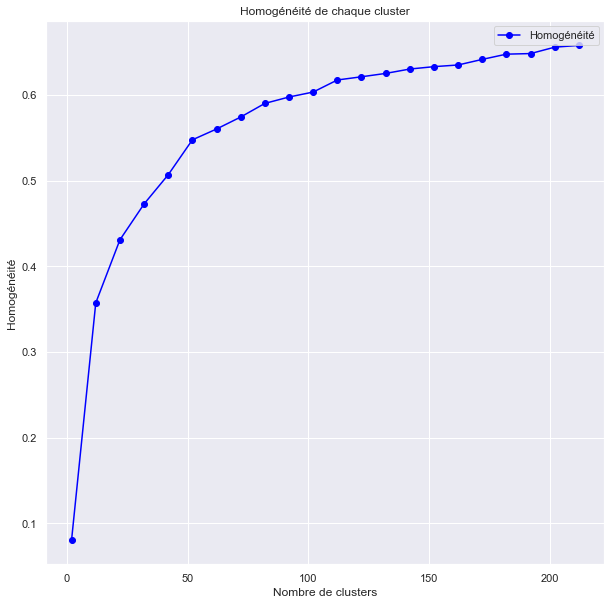

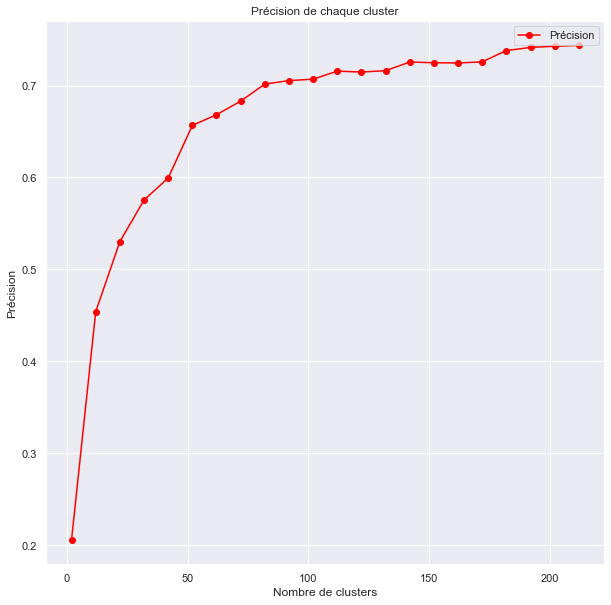

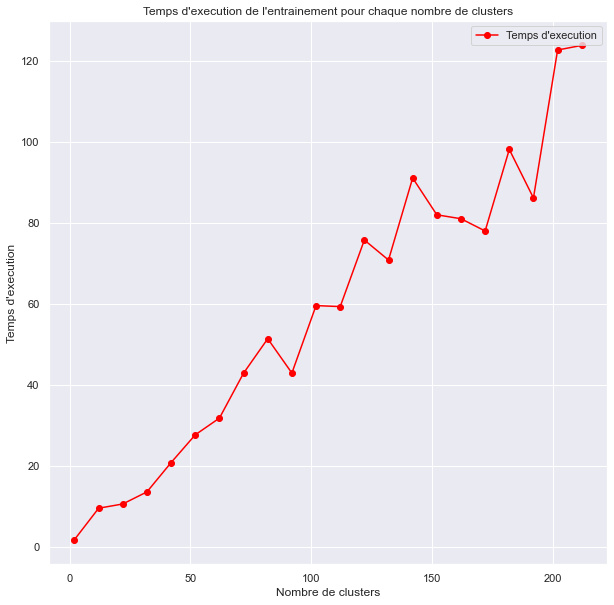

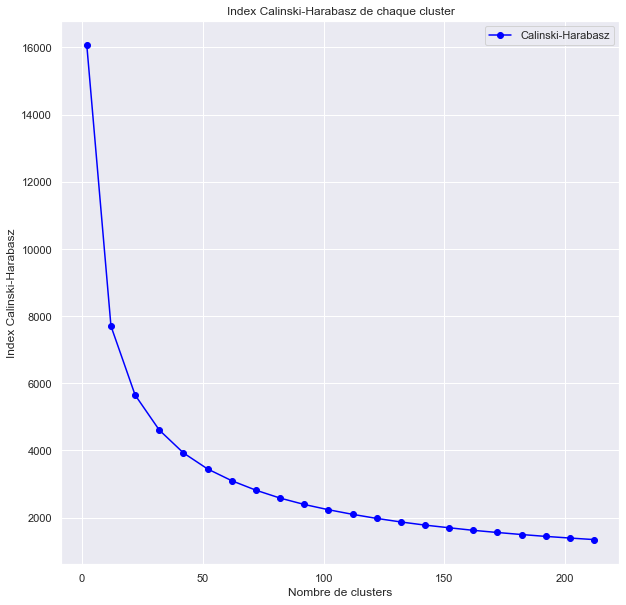

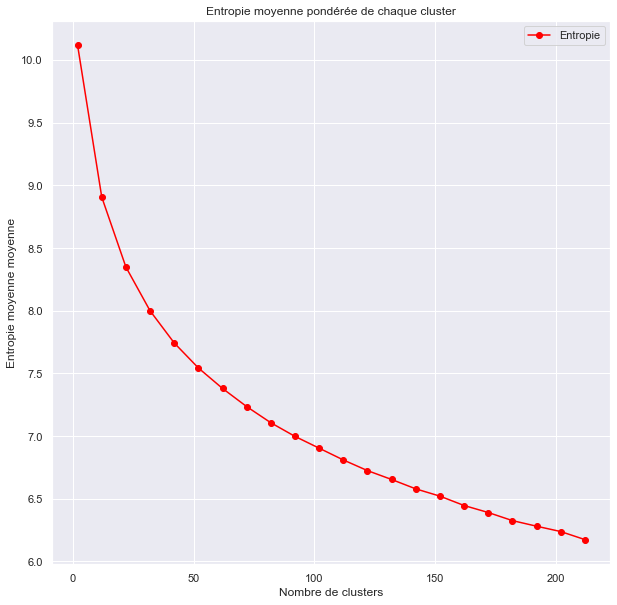

In [21]:
points = range(2, len(inertia)*10, 10)


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, inertia, c = 'r', label = 'inertie', marker='o')
ax.legend(loc='best')
ax.grid('on')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Coût du modèle (Inertie)')
ax.set_title('Inertie en fonction du nombre de clusters')
plt.show()


fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, silhouettes, label='Silhouettes', c='orange', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Score de silhouette moyen')
ax.grid('on')
ax.set_title('Silhouette de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, homogeneite, label='Homogénéité', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Homogénéité')
ax.grid('on')
ax.set_title('Homogénéité de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, precision, label='Précision', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Précision')
ax.grid('on')
ax.set_title('Précision de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, times, label="Temps d'execution", c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel("Temps d'execution")
ax.grid('on')
ax.set_title("Temps d'execution de l'entrainement pour chaque nombre de clusters")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, calinski, label='Calinski-Harabasz', c='blue', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Index Calinski-Harabasz')
ax.grid('on')
ax.set_title('Index Calinski-Harabasz de chaque cluster')
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(10, 10))
ax.plot(points, entropie, label='Entropie', c='red', marker='o')
ax.legend(loc='best')
ax.set_xlabel('Nombre de clusters')
ax.set_ylabel('Entropie moyenne moyenne')
ax.grid('on')
ax.set_title('Entropie moyenne pondérée de chaque cluster')
plt.show()